In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from lib import DihedralAdherence
from lib import PDBMineQuery
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from pathlib import Path
from tqdm import tqdm

In [217]:
PDBMINE_URL = os.getenv("GREEN_PDBMINE_URL")
PROJECT_DIR = 'casp_da'
casp_protein_id = 'T1027'   # 6ya2
proteins = ['T1024', 'T1096', 'T1027', 'T1082', 'T1091', 'T1058', 'T1049', 'T1030', 'T1056', 'T1038', 'T1025', 'T1028']

da = DihedralAdherence(proteins[0], [4,5,6,7], PDBMINE_URL, PROJECT_DIR, kdews=[1,32,64,128], 
                       mode='kde_af')
da.load_results_da()

Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 


5041.1127765100155 3016.77983666189 5502.113555955339
0.0 25.216 24.93199999999999


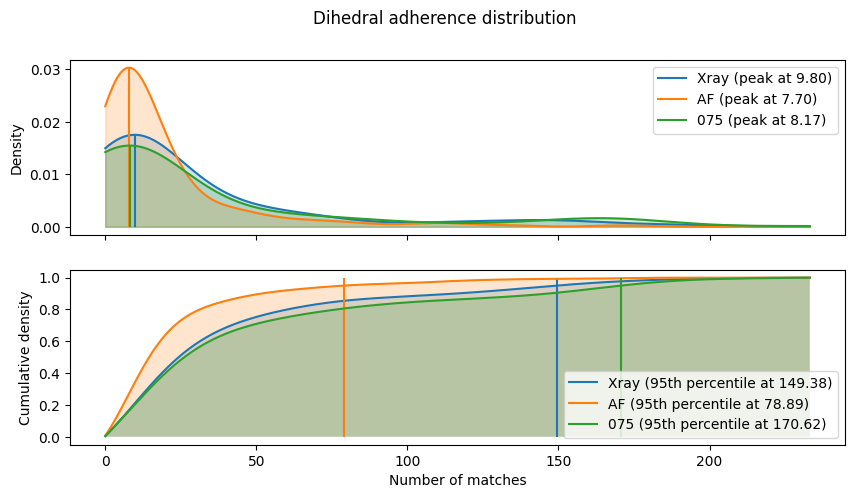

In [150]:
from scipy.stats import gaussian_kde

xray_phi_psi = da.xray_phi_psi.dropna().copy()
af_phi_psi = da.phi_psi_predictions[da.phi_psi_predictions.protein_id == da.alphafold_id].dropna().copy()
results = da.grouped_preds.set_index('protein_id')
xray_phi_psi['rmsd'] = 0
af_phi_psi['rmsd'] = results.loc[da.alphafold_id].RMS_CA

other_id = da.protein_ids[0]
other_phi_psi = da.phi_psi_predictions[da.phi_psi_predictions.protein_id == other_id].dropna().copy()
other_phi_psi['rmsd'] = results.loc[other_id].RMS_CA

print(xray_phi_psi.da.sum(), af_phi_psi.da.sum(), other_phi_psi.da.sum())
print(xray_phi_psi.rmsd.mean(), af_phi_psi.rmsd.mean(), other_phi_psi.rmsd.mean())

df = pd.concat([
    xray_phi_psi, 
    af_phi_psi.drop('da_na', axis=1),
    other_phi_psi.drop('da_na', axis=1)
])

def get_probs(x, da):
    kde = gaussian_kde(da)
    p = kde(x)
    c = np.cumsum(p) / np.sum(p)
    peak = x[np.argmax(p)]
    return p, c, peak

fig, axes = plt.subplots(2, sharex=True, figsize=(10, 5))
x = np.linspace(0, df.da.max(), 1000)

def plot(df, label, color):
    p, c, peak = get_probs(x, df.da)
    axes[0].plot(x, p, color=color, label=f'{label} (peak at {peak:.2f})')
    axes[0].fill_between(x, 0, p, alpha=0.2, color=color)
    axes[0].vlines(peak, 0, p.max(), color=color)
    perc = x[np.argmax(c > 0.95)]
    axes[1].plot(x, c, color=color, label=f'{label} (95th percentile at {perc:.2f})')
    axes[1].vlines(perc, 0, 1, color=color)
    axes[1].fill_between(x, 0, c, alpha=0.2)

colors = sns.color_palette("tab10")
plot(xray_phi_psi, 'Xray', colors[0])
plot(af_phi_psi, 'AF', colors[1])
plot(other_phi_psi, other_id[7:10], colors[2])
axes[0].legend()
axes[0].set_ylabel('Density')
axes[1].legend(loc='lower right')
axes[1].set_xlabel('Number of matches')
axes[1].set_ylabel('Cumulative density')
# axes[0].set_xlim(0, 5000)
# axes[1].set_xlim(0, 5000)
fig.suptitle('Dihedral adherence distribution')
plt.show()

Initializing T1096 ...
Results already exist
Casp ID: T1096 	PDB: 7um1
Structure exists: 'pdb/pdb7um1.ent' 
0.1596548455365378 21.947370285244943


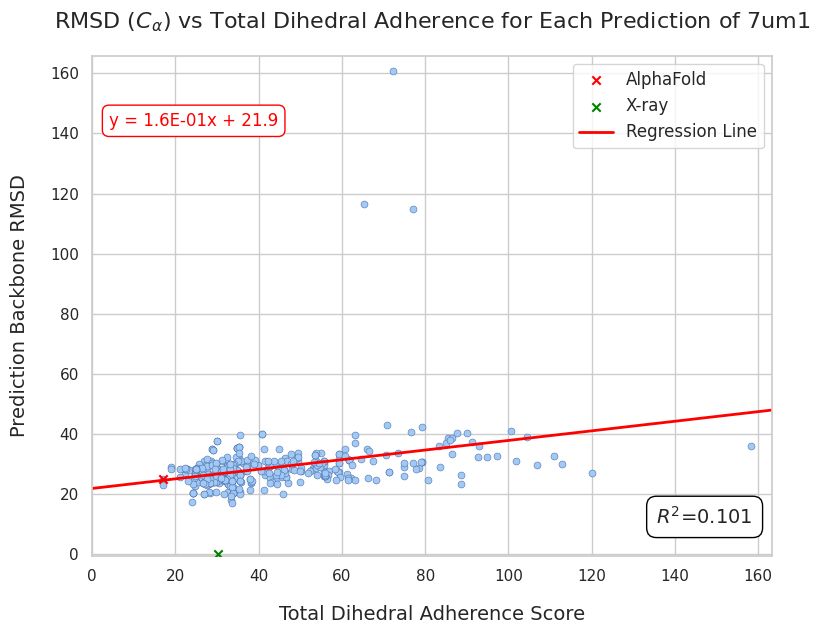

In [106]:
PDBMINE_URL = os.getenv("GREEN_PDBMINE_URL")
PROJECT_DIR = 'casp_da'
proteins = ['T1024', 'T1096', 'T1027', 'T1082', 'T1091', 'T1058', 'T1049', 'T1030', 'T1056', 'T1038', 'T1025', 'T1028']

da = DihedralAdherence(proteins[1], [4,5,6,7], PDBMINE_URL, PROJECT_DIR, kdews=[1,32,64,128], 
                       mode='kde_af')
da.load_results_da()
da.plot_da_vs_rmsd_simple()

In [74]:
rmsds = []
scores = []
thresh = 146.5
for id in da.protein_ids:
    df = da.phi_psi_predictions[da.phi_psi_predictions.protein_id == id].dropna()
    rmsd = da.grouped_preds.set_index('protein_id').loc[id].RMS_CA
    # if rmsd > 30:
        # continue
    if df.shape[0] == 0:
        continue
    score = (df.da < thresh).sum() / df.shape[0]
    scores.append(score)
    rmsds.append(rmsd)

0.2538273243005038


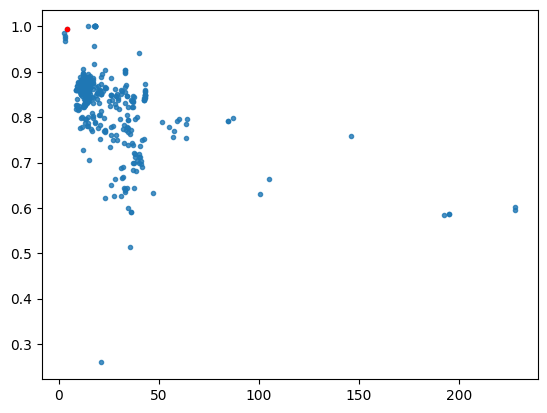

In [75]:
df = da.phi_psi_predictions[da.phi_psi_predictions.protein_id == da.alphafold_id].dropna()
# p, c, peak = get_probs(x, df.da)
perc = (df.da < thresh).sum() / df.shape[0]
rmsd = da.grouped_preds.set_index('protein_id').loc[da.alphafold_id].RMS_CA
model = stats.linregress(rmsds, scores)
print(model.rvalue**2)
plt.scatter(rmsds, scores, marker='.', alpha=0.8)
plt.scatter(rmsd, perc, color='red', marker='.')
plt.show()

In [ ]:
from scipy import stats
# fit linregr to each and find best threshold
PDBMINE_URL = os.getenv("GREEN_PDBMINE_URL")
PROJECT_DIR = 'casp_da'
proteins = ['T1024', 'T1096', 'T1027', 'T1082', 'T1091', 'T1058', 'T1049', 'T1030', 'T1056', 'T1038', 'T1025', 'T1028']
results = []
for thresh in np.linspace(0, 250, 100):
    for protein in proteins:
        print(f'Protein {protein} threshold {thresh}')
        da = DihedralAdherence(protein, [4,5,6,7], PDBMINE_URL, PROJECT_DIR, kdews=[1,32,64,128], 
                        mode='kde_af')
        da.load_results_da()
        scores = []
        rmsds = []
        pbar = tqdm(da.protein_ids)
        pbar.set_description(f'Protein {protein} Threshold {thresh}')
        for id in pbar:
            preds = da.phi_psi_predictions[da.phi_psi_predictions.protein_id == id].dropna()
            if preds.shape[0] == 0:
                continue
            rmsd = da.grouped_preds[da.grouped_preds.protein_id == id].RMS_CA.values
            if len(rmsd) == 0:
                continue
            rmsd = rmsd[0]
            score = (preds.da < thresh).sum() / preds.shape[0]
            scores.append(score)
            rmsds.append(rmsd)
        model = stats.linregress(rmsds, scores)
        results.append((protein, thresh, model.slope, model.intercept, model.rvalue**2, model.pvalue))

    results_df = pd.DataFrame(results, columns=['protein', 'threshold', 'slope', 'intercept', 'rsquared', 'pvalue'])
    results_df.to_csv('results_threshold.csv', index=False)

results = pd.DataFrame(results, columns=['protein', 'threshold', 'slope', 'intercept', 'rsquared', 'pvalue'])
results.to_csv('results_threshold.csv', index=False)

In [49]:

results = pd.read_csv('results_threshold.csv')
results['threshold'] = results['threshold'].round(2)
results.groupby('threshold').describe().sort_values(('rsquared', 'mean'), ascending=False)['rsquared'].head(20)

,count,mean,std,min,25%,50%,75%,max
threshold,,,,,,,,
146.46,12.0,0.278512,0.155180,0.050806,0.196492,0.253142,0.346158,0.578903
148.99,12.0,0.277899,0.157570,0.047990,0.184936,0.255873,0.342594,0.587345
151.52,12.0,0.277849,0.159118,0.038601,0.188770,0.257825,0.343102,0.595368
154.04,12.0,0.276522,0.163434,0.026607,0.184539,0.252087,0.340808,0.607496
143.94,12.0,0.275910,0.153433,0.059579,0.192268,0.243341,0.341028,0.565634
159.09,12.0,0.275868,0.172117,0.024427,0.140984,0.254373,0.341366,0.632508
156.57,12.0,0.275190,0.167217,0.016713,0.172792,0.247366,0.345652,0.620573
161.62,12.0,0.274247,0.175426,0.021844,0.130705,0.256176,0.349175,0.644169
141.41,12.0,0.273506,0.150380,0.071145,0.191182,0.234835,0.331561,0.557023


In [47]:
results.threshold.unique()[58]

146.46464646464645

In [50]:
results[results.threshold == 146.46]

,protein,threshold,slope,intercept,rsquared,pvalue
696,T1024,146.46,-0.003546,0.978893,0.326105,1.021577e-42
697,T1096,146.46,-0.003314,0.968012,0.112023,1.390019e-12
698,T1027,146.46,-0.006384,0.829555,0.225822,2.065307e-28
699,T1082,146.46,-0.025950,1.032426,0.500799,4.171214e-66
700,T1091,146.46,-0.001629,0.867834,0.253886,4.081595e-26
701,T1058,146.46,-0.004543,0.912684,0.578903,1.467341e-89
702,T1049,146.46,-0.009551,0.902445,0.279279,1.603837e-33
703,T1030,146.46,-0.003492,0.972601,0.406316,5.075597e-53
704,T1056,146.46,-0.011014,0.901076,0.252399,3.108223e-31
705,T1038,146.46,-0.006789,0.885929,0.140726,9.428554e-17


# Combined

In [ ]:
PDBMINE_URL = os.getenv("GREEN_PDBMINE_URL")
PROJECT_DIR = 'casp_da'
proteins = ['T1024', 'T1096', 'T1027', 'T1082', 'T1091', 'T1058', 'T1049', 'T1030', 'T1056', 'T1038', 'T1025', 'T1028']


proteins = ['T1024', 'T1096', 'T1027', 'T1082', 'T1091', 'T1058', 'T1049', 'T1030', 'T1056', 'T1038', 'T1025', 'T1028']
# proteins = ['T1024', 'T1027', 'T1082', 'T1091', 'T1058', 'T1049', 'T1030', 'T1056', 'T1038']
results = []
for thresh in np.linspace(0, 250, 100):
    thresh = round(thresh, 2)
    scores = []
    rmsds = []
    protein_ids = []
    for protein in proteins:
        da = DihedralAdherence(protein, [4,5,6,7], PDBMINE_URL, PROJECT_DIR, kdews=[1,32,64,128], 
                            mode='kde_af')
        da.load_results_da()
        pbar = tqdm(da.protein_ids)
        pbar.set_description(f'Protein {protein} Threshold {thresh}')
        for id in pbar:
            preds = da.phi_psi_predictions[da.phi_psi_predictions.protein_id == id].dropna()
            if preds.shape[0] == 0:
                continue
            rmsd = da.grouped_preds[da.grouped_preds.protein_id == id].RMS_CA.values
            if len(rmsd) == 0:
                continue
            rmsd = rmsd[0]
            score = (preds.da < thresh).sum() / preds.shape[0]
            scores.append(score)
            rmsds.append(rmsd)
            protein_ids.append(protein)
        
    model = stats.linregress(rmsds, scores)
    results.append((thresh, model.slope, model.intercept, model.rvalue**2, model.pvalue))

results_df = pd.DataFrame(results, columns=['threshold', 'slope', 'intercept', 'rsquared', 'pvalue'])
results_df.to_csv('results_threshold_combined.csv', index=False)

In [114]:
rmsds = np.array(rmsds)
scores = np.array(scores)
protein_ids = np.array(protein_ids)

In [115]:
r = rmsds[rmsds < 60]
s = scores[rmsds < 60]
i = protein_ids[rmsds < 60]

In [116]:
model = stats.linregress(r, s)
model.rvalue**2

0.14103848669644053

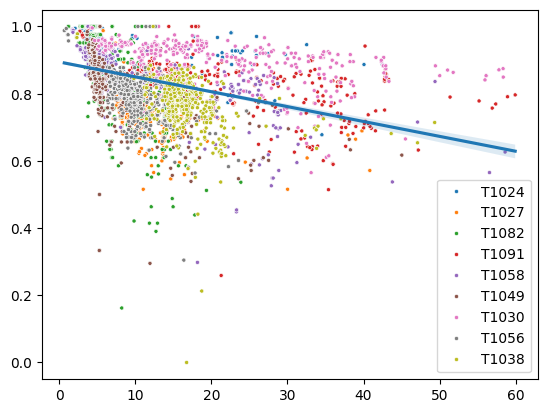

In [117]:
sns.scatterplot(x=r, y=s, hue=i, marker='.')
sns.regplot(x=r, y=s, scatter=False)
plt.show()